# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "kenza"
ln1 = "benjelloun"
fn2 = "matthieu"
ln2 = "dubois"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_benjelloun_kenza_and_dubois_matthieu.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
 
   $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j =  w[j]
        w[j] += 1./ lips_const[j] * A[:,j].dot(residuals)
        # update residuals:
        residuals += ( A[:,j].dot(old_w_j) - A[:,j].dot(w[j]) )
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= 1./ lips_const[j] * gradient[j]
        # update gradient:
        gradient -= ( gram[:,j] * (old_w_j - w[j]) )
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

### Compute a precise minimum with your favorite solver

In [6]:
from scipy import linalg
w = linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
obj = 0.5 * np.linalg.norm(A.dot(w) - b) ** 2

### Compare the performance of cyclic and greedy CD as function of iterations

Text(0.5, 0, 'iterations')

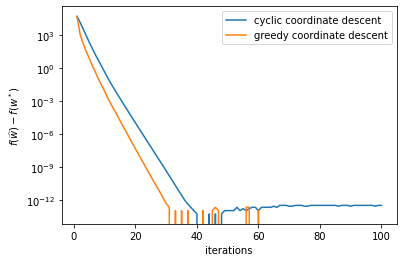

In [7]:
w_cyclic,obj_cyclic = cyclic_cd(A,b,10000)
w_greedy,obj_greedy = greedy_cd(A,b,10000)
iter_range = np.arange(obj_cyclic.shape[0])+1
plt.plot(iter_range, obj_cyclic - obj, label='cyclic coordinate descent')
plt.plot(iter_range, obj_greedy - obj, label='greedy coordinate descent')
plt.legend()
plt.yscale('log')
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')

Greedy CD is faster then Cyclic GD as function of iterations

### From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

- Greedy CD for L2 regularized logistic regression : Greedy CD is not efficient and too expensive for L2 regularized logistic regression as it updates the gradients for each coordinate with a constant cost.
- Greedy CD to solve OLS with 100,000 features : With 100,000 features, greedy CD would be too costly as it evaluates the whole gradient vector to find the best index and the best descent. 

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
  Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

Let's show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

Let f be the following function : 
$$ f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

Then :    

$$ \partial f_{j}(w) =  \sum_{i=1}^{n} (- y_i X_{ij}^\top / 1 + e^{- y_i w^\top x_i} )  + \lambda \partial \left|  w_j \right|  $$

So, we have :

$$\widehat{w} = argmin f_j(w) \Leftrightarrow 0 \in \partial f(\widehat{w}) \Leftrightarrow \frac{1}{\lambda} \sum_{i=1}^{n} (- y_i X_{ij}^\top / 1 + e^{- y_i \hat w^\top x_i} )\in\partial \left| \hat w_j \right| $$


Let's show first that : $\lambda \geq \lambda_{max} \Leftarrow \hat w = 0$

if $\hat w = 0 \Rightarrow \hat w_i = 0 $ $\forall i$  $ \Rightarrow ∂ \left| \hat w_j \right| = [-1,1]$ 

So : $$-\lambda\le \sum_{i=1}^{n} (- y_i X_{ij}^\top / 1 + e^{- y_i \hat w^\top x_i} ) \le \lambda$$

$$-\lambda\le \sum_{i=1}^{n} (- y_i X_{ij}^\top / 2 ) \le \lambda$$

$$\frac{1}{2}\left\| X^\top y \right\|_{\infty} \le \lambda$$


Nown let's show that : $\lambda \geq \lambda_{max} \Rightarrow \hat w = 0$


We have 

$\left| \sum_{i=1}^{n} y_{i}w^{T}x_{i}\right| = \left| \sum_{j=1}^{n} w_{j}\sum_{i=1}^{n}y_{i}X_{ij}\right| \le \sum_{j=1}^{n}\left| w_{j} \right|\left\| X^{T} y\right\|_{\infty} \le 2\lambda\left\| w \right\|_{1}$

So, using Jensen's inequality :             
$f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 \geqslant  n\mathrm{log} ( 1 + e^{- \sum_{i=1}^{n}y_i w^\top x_i} ) + \lambda \Vert w \Vert_1 \geqslant n\mathrm{log} ( 1 + e^{- 2\lambda\left\| w \right\|_{1}} ) + \lambda \Vert w \Vert_1 = ng ( \frac{2 λ}{n} \lVert w \rVert_{1} )$

Where $g(x) = log(1 + e^{-x}) + \frac{x}{2}$ 
which is an increasing function so :     

$$f(w)\geqslant ng ( \frac{2 λ}{n} \lVert w \rVert_{1} ) \geqslant ng(0) = f(0)$$

We also have :    

$$\hat w \in \mathrm{arg \, min} f(w)$$

Which means $f(\hat w)=f(0)$ and finally $\hat w=0$

To conclude : $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.



<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
  Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

Let f be the following function : 
$$ f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $$

So : 

$$ \frac{\partial f(w)}{\partial w_{j}} = \sum_{i=1}^{n} (- y_i x_{ij} / 1 + e^{- y_i w^\top x_i} ) $$ 

And :          
 
$$ \frac{\partial^{2}f(w) }{\partial w_{j}^{2}} = \sum_{i=1}^{n} y_{i}^{2}x_{ij}^{2} exp(y_{i}w^\top x_{i})/(1+exp(y_{i}w^\top x_{i}))^{2} $$

We have : $\forall x$ $$ (1+x^{2})\ge 4x  $$ and  $\forall i$ $$y_{i}^{2} = 1 $$

So : 
$$\left| \frac{\partial^{2}f(w) }{\partial w_{j}^{2}} \right|\le \frac{1}{4}\sum_{i=1}^{n} y_{i}^{2}x_{ij}^{2}  $$

$$\le \frac{1}{4}\sum_{i=1}^{n}x_{ij}^{2} = \frac{1}{4} \left\| Xj \right\|^{2}$$

Which means we can have $ \frac{1}{4} \left\| Xj \right\|^{2}$ as Lipschitz constant.








<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [8]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)

    all_objs = []
    
    # TODO
    lips_const = np.sum(X ** 2, axis=0)/4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j =  np.sum( - y * X[:,j] * sigmoid( - y * Xw) )
            w[j] = soft_thresh(old_w_j - grad_j / lips_const[j] , lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += ( ( w[j] - old_w_j )  * X[:,j] )
            #END TODO
            
        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, np.array(all_objs)

In [9]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=True)

In [10]:
w_cd_logreg, objs_cd_logreg = cd_logreg(A,b,lamb,1000)

Text(0.5, 1.0, 'Performance of proximal CD for Sparse logistic regression')

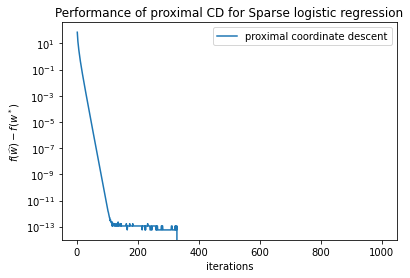

In [11]:
iter_range = np.arange(objs_cd_logreg.shape[0])+1
plt.plot(iter_range, objs_cd_logreg - objs_cd_logreg[-1], label='proximal coordinate descent')
plt.legend()
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')
plt.yscale('log')
plt.title('Performance of proximal CD for Sparse logistic regression')

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [12]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [13]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [14]:
def lasso_proxGD(X,y,lamb,n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    XT_X = np.dot(X.T,X)
    XT_y = np.dot(X.T,y)

    all_objs = np.empty(n_iter)
    
    lips_const = np.linalg.norm(X, ord=2) ** 2
    
    for t in range(n_iter):
        w = soft_thresh(w - 1. / lips_const * (XT_X.dot(w) - XT_y), 
                        lamb / lips_const)
        
        all_objs[t] = 0.5 * np.linalg.norm(X.dot(w) - y) ** 2 + lamb * norm(w, ord=1)
    
    return w, all_objs
  
def lasso_proxCD(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    residuals = X.dot(w) - y

    all_objs = np.empty(n_iter)
    
    lips_const = np.sum(X ** 2, axis=0)
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            w[j] = soft_thresh(old_w_j - 1. / lips_const[j] * X[:,j].dot(residuals) ,
                               lamb / lips_const[j])
            
            if old_w_j != w[j]:
                residuals += ( - X[:,j].dot(old_w_j) + X[:,j].dot(w[j]) )
            
        all_objs[t] = (residuals ** 2).sum() / 2. + lamb * norm(w, ord=1)
    
    return w, all_objs

In [15]:
w_proxCD, objs_proxCD = lasso_proxCD(X,y,lambd,1000)
w_proxGD, objs_proxGD = lasso_proxGD(X,y,lambd,1000)

Text(0.5, 1.0, 'Comparision of objective function error with Lasso for prox GD and prox CD')

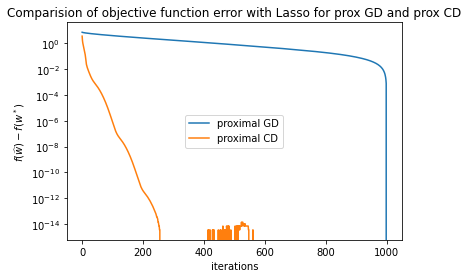

In [16]:
iter_range = np.arange(objs_proxGD.shape[0])
plt.plot(iter_range, objs_proxGD - objs_proxGD[-1], label='proximal GD')
plt.plot(iter_range, objs_proxCD - objs_proxCD[-1], label='proximal CD')
plt.legend()
plt.yscale('log')
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')
plt.title('Comparision of objective function error with Lasso for prox GD and prox CD')

We can notice that proximal CD performs better and converges faster than proximal GD.